In [ ]:
import os
import zipfile

In [ ]:
# !pip install numpy keras tf-explain matplotlib
# !pip install keras_tuner

In [ ]:
import numpy as np
import keras
from keras import layers
# from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
import matplotlib.pyplot as plt
from keras.applications.mobilenet_v2 import preprocess_input


batch_size = 128
epochs = 15
num_classes = 4
input_shape = (150, 150, 3)

In [ ]:
results_dir = '../results'
zip_path = '/content/retinal-oct-sample.zip'
def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
        print(f"Created directory {os.path.abspath(extract_to)} for extraction.")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted all files from {os.path.abspath(zip_path)} to {os.path.abspath(extract_to)}.")
extract_zip(zip_path, results_dir)


Created directory /results for extraction.
Extracted all files from /content/retinal-oct-sample.zip to /results.


In [ ]:
IMG_SIZE =  (150, 150)
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

train_ds = keras.utils.image_dataset_from_directory(
    '/results/train_sample2',
    image_size= IMG_SIZE,
    batch_size = batch_size,
    label_mode="categorical"
)

test_ds = keras.utils.image_dataset_from_directory(
    '/results/test',
    image_size= IMG_SIZE,
    batch_size = batch_size,
    label_mode="categorical",
    shuffle = False
)

val_ds = keras.utils.image_dataset_from_directory(
    '/results/val',
    image_size= IMG_SIZE,
    batch_size = batch_size,
    label_mode="categorical"
)

def preprocess_data(images, labels):
    return preprocess_input(images), labels

# Apply the preprocessing
train_ds = train_ds.map(preprocess_data)
val_ds = val_ds.map(preprocess_data)
test_ds = test_ds.map(preprocess_data)

Found 4000 files belonging to 4 classes.
Found 968 files belonging to 4 classes.
Found 32 files belonging to 4 classes.


AttributeError: '_MapDataset' object has no attribute 'class_names'

In [ ]:
from keras.applications import MobileNetV2
from keras.optimizers import Adam

def build_transfer_model(input_shape, num_classes):
    # Load MobileNetV2 without the top classification layer
    # alpha=0.5 makes the model smaller/faster (optional, can be removed for higher accuracy)
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        alpha=1.0 # Changed to 1.0 for standard performance, use 0.5 for speed
    )

    # Freeze the base model initially
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# # Initialize
# input_shape = (IMG_SHAPE[0], IMG_SHAPE[1], 3)
# num_classes = 4

model = build_transfer_model(input_shape, num_classes)

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/tmp/ipython-input-4127049990.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 684ms/step - accuracy: 0.2796 - loss: 1.8673 - val_accuracy: 0.6562 - val_loss: 0.9319
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.4010 - loss: 1.3300 - val_accuracy: 0.6875 - val_loss: 0.7693
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.5064 - loss: 1.1332 - val_accuracy: 0.8125 - val_loss: 0.6754
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.5445 - loss: 1.0765 - val_accuracy: 0.8438 - val_loss: 0.6082
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.5751 - loss: 0.9949 - val_accuracy: 0.8750 - val_loss: 0.5319
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.5956 - loss: 0.9522 - val_accuracy: 0.9375 - val_loss: 0.4936
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.6296 - loss: 0.9054 - val_accuracy: 0.9375 - val_loss: 0.4382
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.6417 - loss: 0.8785 - val_accuracy:

In [ ]:
base_model_layer = None
for layer in model.layers:
    # Check if the layer is a Model/Functional layer (like MobileNetV2)
    if hasattr(layer, 'layers') and len(layer.layers) > 0:
        base_model_layer = layer
        break

if base_model_layer is None:
    print("Error: Could not find the base model! Check model.summary().")
else:
    print(f"Base model found: {base_model_layer.name}")

    # 2. Unfreeze the base model
    base_model_layer.trainable = True

    # 3. Freeze all but the last 30 layers of the base model
    for layer in base_model_layer.layers[:-30]:
        layer.trainable = False

    # 4. Recompile with LOW Learning Rate (Crucial!)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-5), # Very low LR to prevent destroying weights
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # 5. Train again (Fine-Tuning)
    print("Starting Fine-Tuning...")
    history_fine = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=callbacks
    )

Base model found: mobilenetv2_1.00_224
Starting Fine-Tuning...
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 570ms/step - accuracy: 0.4826 - loss: 1.3289 - val_accuracy: 0.9062 - val_loss: 0.3035
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - accuracy: 0.5907 - loss: 1.0046 - val_accuracy: 0.8438 - val_loss: 0.3561
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.6601 - loss: 0.8381 - val_accuracy: 0.8438 - val_loss: 0.3786
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.7267 - loss: 0.7065 - val_accuracy: 0.8125 - val_loss: 0.4000


In [23]:
# Evaluate
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f}")

# Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)

# Get true labels
# Since we didn't shuffle test_ds, we can iterate to get labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8830 - loss: 0.3384
Test Accuracy: 0.8957
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 677ms/step


In [26]:
print("\nDetailed Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=['CNV', 'DME', 'DRUSEN', 'NORMAL']))


Detailed Classification Report:

              precision    recall  f1-score   support

         CNV       0.88      0.88      0.88       242
         DME       0.96      0.85      0.90       242
      DRUSEN       0.84      0.90      0.87       242
      NORMAL       0.91      0.95      0.93       242

    accuracy                           0.90       968
   macro avg       0.90      0.90      0.90       968
weighted avg       0.90      0.90      0.90       968



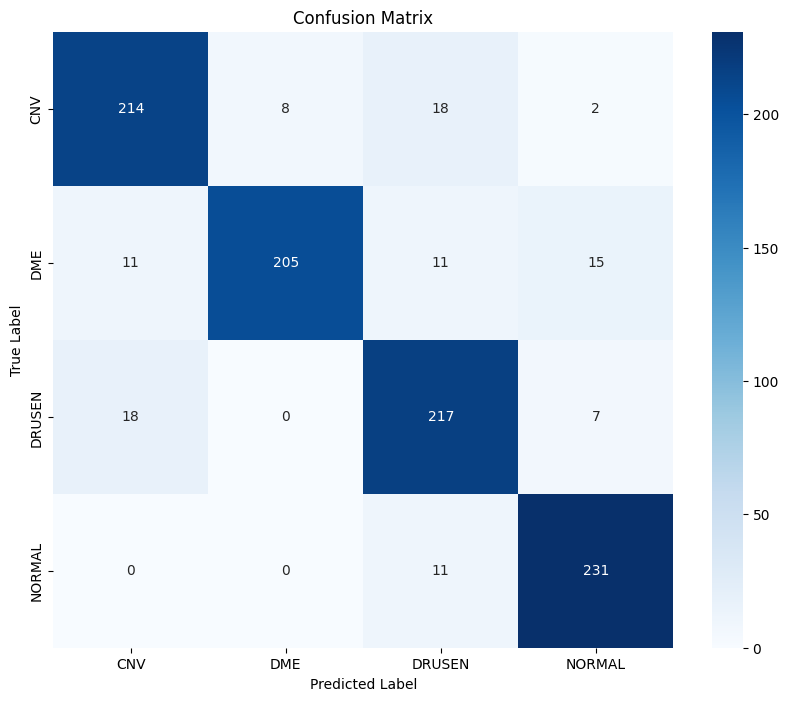

In [24]:
cm = confusion_matrix(y_true, y_pred)

# 5. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

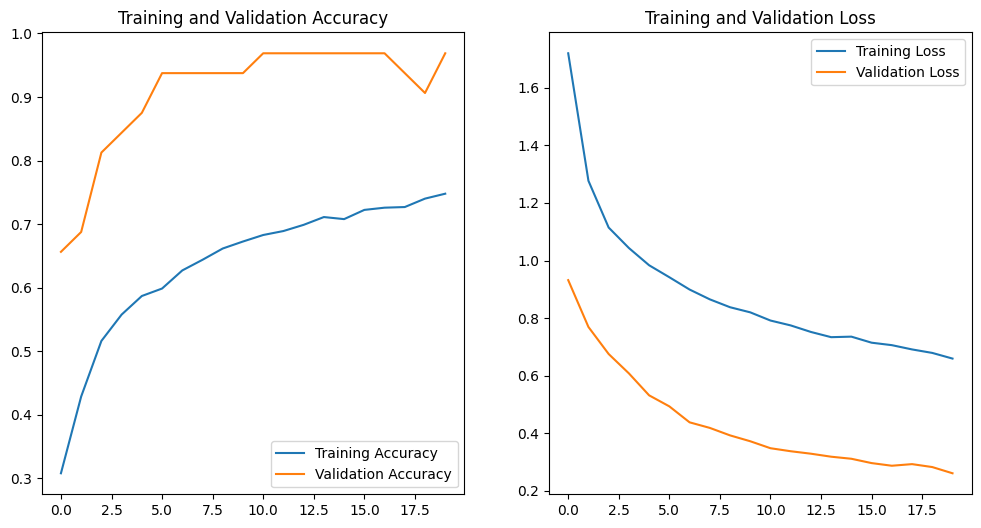

In [25]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import shap

# 1. Get Data (Same as before)
for images, labels in test_ds.take(1):
    test_batch = images.numpy()

images_to_explain = test_batch[:5]  # Explain first 5 images

# 2. Define the Masker
# This tells SHAP: "When you want to hide a part of the image, use this method."
# "inpaint_telea" blurs the hidden parts. 
# We pass the shape of a SINGLE image (e.g., 150, 150, 3).
masker = shap.maskers.Image("inpaint_telea", images_to_explain[0].shape)

# 3. Create the Explainer
# We pass the MODEL and the MASKER.
# This automatically selects 'PartitionExplainer', which is optimized for images.
explainer = shap.Explainer(model, masker)

# 4. Calculate SHAP values
# This generates the explanation object.
print("Calculating SHAP values...")
shap_values = explainer(images_to_explain, max_evals=500, batch_size=50)

# 5. Visualize
# Note: The syntax for plotting this specific output is slightly different.
shap.image_plot(shap_values, show=False)
plt.savefig('shap_explanation.png', bbox_inches="tight", dpi=300)

Based on the image you uploaded, here is the detailed interpretation of your SHAP analysis.

1. What are we looking at?
First, a critical distinction: These are OCT (Optical Coherence Tomography) scans, not Fundus photos.

Fundus photos are "face-on" pictures of the back of the eye (showing veins and the optic disc).

OCT scans (which you have here) are cross-sections (side views) showing the layers of the retina. The white "hills and valleys" are the physical layers of tissue.

2. How to Read the Grid
Rows: Each row represents one single image (one patient scan) being analyzed.

Leftmost Column: This is the raw input image fed into the model.

Columns "Output 0" to "Output 3": These represent the 4 possible disease classes your model predicts (likely: CNV, DME, Drusen, and Normal).

Output 1 (Column 3) shows the strongest Red activity. This indicates your model is predicting Class 1 for all these images.

3. Interpreting the Colors (The "Why")
Red (Pink) Blocks: These regions increase the probability of that specific class.

Look at "Output 1": The red blocks are clustered around the white retinal layers (the distorted tissue). This is a good sign. It means the model is looking at the actual tissue deformation to make its diagnosis.

Blue Blocks: These regions decrease the probability of that class.

Look at "Output 0": You see significant blue patches. The model is seeing features in the retina that make it say, "This definitely does NOT look like Class 0."

Gray: These areas are neutral and didn't influence the decision.

4. Critical Assessment: Is the Model "Cheating"?
This plot reveals a few important characteristics about your model's behavior:

The "Blocky" Appearance: The heatmaps are made of large squares. This is normal when using PartitionExplainer or KernelExplainer with a lower resolution or nsamples. It gives you a general "region of interest" rather than pixel-perfect precision.

Positive Check (Anatomy): In the "Output 1" column, the red activation is mostly centered on the retina itself (the white wavy part). The model is correctly ignoring the large black space at the top (the vitreous humor), which is exactly what you want.

Potential Noise: There is some "bleeding" of red color into the black background in the 2nd and 4th rows. This is minor, but ideally, you want the red to be tightly hugging the white tissue layers.

Summary
Your model is confidently predicting Class 1 for these images, and it is doing so by focusing on the shape and texture of the retinal layers, which validates that it is learning relevant medical features rather than background noise.

Next Step: Do you know which specific disease corresponds to "Output 1" (e.g., is it Diabetic Macular Edema or CNV)? If you tell me the label, I can explain what specific shape (like "fluid cysts") the model is likely detecting in those white layers.